In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import h5py

In [2]:
def avg_time(wt):
    avg_time = np.mean(wt)
    std_time = np.std(wt)
    return (avg_time, std_time)

def all_avg_times(all_walltimes):
    averages = []
    stds = []
    for wt in all_walltimes:
        time_avg, time_std = avg_time(wt)
        averages.append(time_avg)
        stds.append(time_std)
    return (np.array(averages), np.array(stds))

In [3]:
# get digits from the filenames.
def get_all_digits(strn):
    digit_str = []
    for ch in strn:
        if ch.isdigit():
            digit_str.append(ch)
    return ''.join(digit_str)

def get_num_nodes(fnames):
    num_nodes = np.array([int(get_all_digits(strn.replace('.h5', ''))) for strn in fnames])
    return num_nodes

In [4]:
def fit_walltimes(num_nodes, avg_times):
    # Fit a line to the data in the chosen log scale. 
    linreg_result = linregress(np.log2(num_nodes), np.log10(avg_times))
    fit_x = np.linspace(np.min(num_nodes), np.max(num_nodes), num=50)
    alpha = linreg_result.slope
    beta = linreg_result.intercept
    fit_y = 10.0 ** np.log2(2.0 ** beta * fit_x ** alpha)
    return (linreg_result, fit_x, fit_y)

In [5]:
def analyze_case(h5_filenames):
    walltimes = [h5py.File(f)["walltimes"][()] for f in h5_filenames]
    step_times = [np.mean(h5py.File(f)["step_times"][()]) for f in h5_filenames]
    averaging_times = [np.mean(h5py.File(f)["averaging_times"])[()] for f in h5_filenames]
    total_walltimes = [h5py.File(f)["total_walltime"][0] for f in h5_filenames]
    avg_times, std_times = all_avg_times(walltimes)
    num_nodes = get_num_nodes(h5_filenames)
    linreg_result, fit_x, fit_y = fit_walltimes(num_nodes, avg_times)
    total_linreg_result, total_fit_x, total_fit_y = fit_walltimes(num_nodes, np.array(total_walltimes))
    results = {}
    results["total_walltimes"] = np.array(total_walltimes)
    results["step_times"] = np.array(step_times)
    results["averaging_times"] = np.array(averaging_times)
    results["num_nodes"] = num_nodes
    results["avg_times"] = avg_times
    results["std_times"] = std_times
    results["linreg_result"] = linreg_result
    results["fit_x"] = fit_x
    results["fit_y"] = fit_y    
    results["total_linreg_result"] = total_linreg_result
    results["total_fit_x"] = total_fit_x
    results["total_fit_y"] = total_fit_y
    return results

In [6]:
dir = "../data"
data_files = os.listdir(dir)
off_node_data_files = [s for s in data_files if "out_" in s and "h5" in s and "out_case_two_" not in s]
off_node_filenames = [dir + '/' + f for f in off_node_data_files]
off_node_case_two_data_files = [s for s in data_files if "out_case_two_" in s and "h5" in s]
off_node_case_two_filenames = [dir + '/' + f for f in off_node_case_two_data_files]
same_node_filenames = [dir + '/' + s for s in data_files if "same_node_" in s and "case_two" not in s]
same_node_case_two_data_files = [s for s in data_files if "same_node_case_two_" in s and "h5" in s]
same_node_case_two_filenames = [dir + '/' + f for f in off_node_case_two_data_files]

off_node_results = analyze_case(off_node_filenames)
off_node_case_two_results = analyze_case(off_node_case_two_filenames)
same_node_results = analyze_case(same_node_filenames)
same_node_case_two_results = analyze_case(same_node_case_two_filenames)

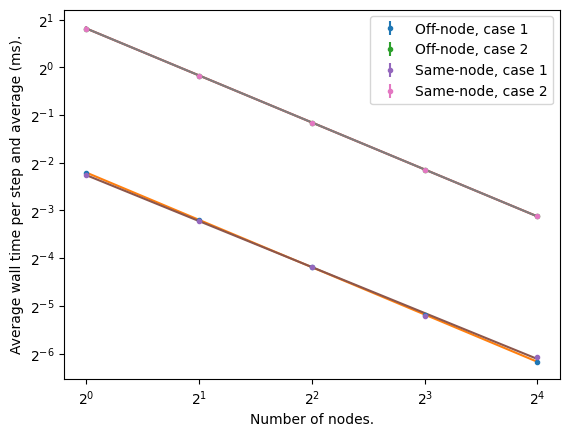

In [7]:
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.errorbar(off_node_results["num_nodes"], off_node_results["avg_times"], yerr=off_node_results["std_times"], \
            linestyle='', marker='.', label="Off-node, case 1")
ax.plot(off_node_results["fit_x"], off_node_results["fit_y"])

ax.errorbar(off_node_case_two_results["num_nodes"], off_node_case_two_results["avg_times"], yerr=off_node_case_two_results["std_times"], \
            linestyle='', marker='.', label="Off-node, case 2")
ax.plot(off_node_case_two_results["fit_x"], off_node_case_two_results["fit_y"])

ax.errorbar(same_node_results["num_nodes"], same_node_results["avg_times"], yerr=same_node_results["std_times"], \
            linestyle='', marker='.', label="Same-node, case 1")
ax.plot(same_node_results["fit_x"], same_node_results["fit_y"])

ax.errorbar(same_node_case_two_results["num_nodes"], same_node_case_two_results["avg_times"], yerr=same_node_case_two_results["std_times"], \
            linestyle='', marker='.', label="Same-node, case 2")
ax.plot(same_node_case_two_results["fit_x"], same_node_case_two_results["fit_y"])

ax.set_xlabel("Number of nodes.")
ax.set_ylabel("Average wall time per step and average (ms).")
ax.legend()
plt.savefig("../plots/times_step_nodes.png")

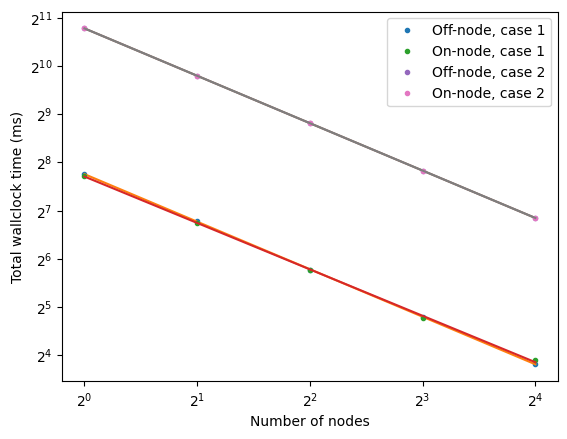

In [8]:
fig2, ax2 = plt.subplots()
ax2.set_xscale('log', base=2)
ax2.set_yscale('log', base=2)
ax2.plot(off_node_results["num_nodes"], off_node_results["total_walltimes"], '.', label="Off-node, case 1")
ax2.plot(off_node_results["total_fit_x"], off_node_results["total_fit_y"], '-')
ax2.plot(same_node_results["num_nodes"], same_node_results["total_walltimes"], '.', label="On-node, case 1")
ax2.plot(same_node_results["total_fit_x"], same_node_results["total_fit_y"], '-')
ax2.plot(off_node_case_two_results["num_nodes"], off_node_case_two_results["total_walltimes"], '.', label="Off-node, case 2")
ax2.plot(off_node_case_two_results["total_fit_x"], off_node_case_two_results["total_fit_y"], '-')
ax2.plot(same_node_case_two_results["num_nodes"], same_node_case_two_results["total_walltimes"], '.', label="On-node, case 2")
ax2.plot(same_node_case_two_results["total_fit_x"], same_node_case_two_results["total_fit_y"], '-')
ax2.set_xlabel("Number of nodes")
ax2.set_ylabel("Total wallclock time (ms)")
plt.legend()
plt.savefig("../plots/total_time_nodes.png")

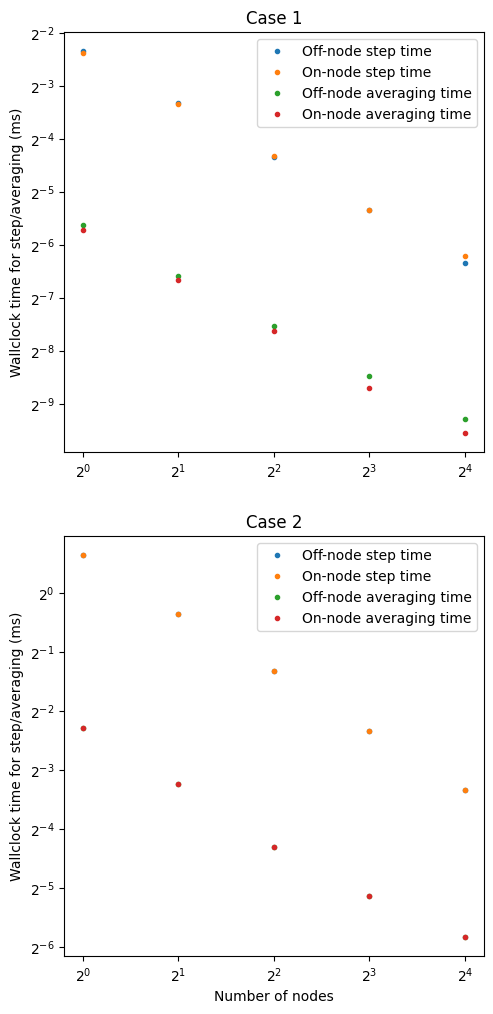

In [15]:
fig3, ax3 = plt.subplots(2,1)
ax3[0].set_xscale('log', base=2)
ax3[0].set_yscale('log', base=2)
ax3[1].set_xscale('log', base=2)
ax3[1].set_yscale('log', base=2)
fig3.set_figwidth(6.0)
fig3.set_figheight(12.0)
ax3[0].set_box_aspect(1)
ax3[1].set_box_aspect(1)

ax3[0].plot(off_node_results["num_nodes"], off_node_results["step_times"], '.', label="Off-node step time")
ax3[0].plot(same_node_results["num_nodes"], same_node_results["step_times"], '.', label="On-node step time")
ax3[0].plot(off_node_results["num_nodes"], off_node_results["averaging_times"], '.', label="Off-node averaging time")
ax3[0].plot(same_node_results["num_nodes"], same_node_results["averaging_times"], '.', label="On-node averaging time")
ax3[0].set_title("Case 1")

ax3[1].plot(off_node_case_two_results["num_nodes"], off_node_case_two_results["step_times"], '.', label="Off-node step time")
ax3[1].plot(same_node_case_two_results["num_nodes"], same_node_case_two_results["step_times"], '.', label="On-node step time")
ax3[1].plot(off_node_case_two_results["num_nodes"], off_node_case_two_results["averaging_times"], '.', label="Off-node averaging time")
ax3[1].plot(same_node_case_two_results["num_nodes"], same_node_case_two_results["averaging_times"], '.', label="On-node averaging time")
ax3[1].set_title("Case 2")

ax3[1].set_xlabel("Number of nodes")
ax3[0].set_ylabel("Wallclock time for step/averaging (ms)")
ax3[1].set_ylabel("Wallclock time for step/averaging (ms)")
ax3[0].legend()
ax3[1].legend()
plt.savefig("../plots/node_step_averaging.png")

In [13]:
print(off_node_results["total_linreg_result"].slope)
print(same_node_results["total_linreg_result"].slope)
print(off_node_case_two_results["total_linreg_result"].slope)
print(same_node_case_two_results["total_linreg_result"].slope)

-0.29675561762440833
-0.2897162729453805
-0.29586005404980276
-0.29586005404980276
